---
title: "Using the electric-units package"
description: "How to make use of the objects in the electric-units package for managing data about the electricity grid and appliances."
branch: master
main: usage.ipynb
tags:
  - electric-units
  - data-transformation
  - energy
  - power
---

# Electric Units


We often work with power samples and energy cost data. This requires a few common data transformations:

* Data is sampled using different timezones - these need to be matched
* Costs refer to energy, while samples are of momentary power - the power samples need to be combined to express energy over a time period.
* Time periods are often prescriptive - we often summarise our energy use into those prespribed periods.


In [2]:
import pandas as pd
from os import listdir
from os.path import isfile, join

We start with some power sample data, showing the power at the time of observation. This has been loaded into a DataFrame.

In [3]:
data_dir = './data'
data_frames = []
for file_name in listdir(data_dir):
    df = pd.read_csv(join(data_dir, file_name), parse_dates=['Timestamp'])
    data_frames.append(df)

power_sample_data = pd.concat(data_frames)
power_sample_data.sort_values(by=['Timestamp'], inplace=True)
power_sample_data.head(8)

,Timestamp,Demand (W)
0,2020-01-03 00:01:00+00:00,0.00
1,2020-01-03 00:06:00+00:00,76.81
2,2020-01-03 00:11:00+00:00,77.20
3,2020-01-03 00:16:00+00:00,74.29
4,2020-01-03 00:21:00+00:00,0.35
5,2020-01-03 00:26:00+00:00,2.67
6,2020-01-03 00:31:00+00:00,0.00
7,2020-01-03 00:36:00+00:00,0.00


## Power sample objects

This DataFrame has a series of `datetime` and `float` values.

The electric-units package allows us to work with `WattSample` objects, which have abilities beyond the basic classes of datetime and float.

We can get a series of WattSamples from our data using:
```
power_sample_data.apply(lambda x: WattSample(x['Demand (W)'], x['Timestamp']), axis=1)
```

And we will add that to our existing DataFrame in the 'power_samples' column:

In [4]:
from electric_units import WattSample

def create_power_samples(row):
    return WattSample(watts=row['Demand (W)'], moment=row['Timestamp'])

power_sample_data['power_samples'] = power_sample_data.apply(create_power_samples, axis=1)
power_sample_data.tail()

,Timestamp,Demand (W),power_samples
283,2020-01-20 23:36:00+00:00,75.20,"WattSample(watts=75.2, moment=Timestamp('2020-..."
284,2020-01-20 23:41:00+00:00,72.23,"WattSample(watts=72.23, moment=Timestamp('2020..."
285,2020-01-20 23:46:00+00:00,0.32,"WattSample(watts=0.32, moment=Timestamp('2020-..."
286,2020-01-20 23:51:00+00:00,0.00,"WattSample(watts=0.0, moment=Timestamp('2020-0..."
287,2020-01-20 23:56:00+00:00,0.40,"WattSample(watts=0.4, moment=Timestamp('2020-0..."


## Electrical Energy object

The WattSample object has some abilities beyond the standard python classes; one of those, which we will use here, is the ability to generate an `ElectricalEnergy` object from a list of them.

The `ElectricalEnergy` object expects a list of WattSample objects and requires these objects to gave a propery of both time and power.

We can summarise the total energy in the power samples using:
```
ElectricalEnergy.from_power_samples(power_sample_data['power_samples'])
```

This will interpolate between each power sample and measure the area under the graph between each pair of samples. Creating a single expression of the energy used between 2 time periods. This energy has a `start`, and an `end` which are both timezone aware, and a measure of the energy in kwh.

In [5]:
from electric_units import ElectricalEnergy

total_energy = ElectricalEnergy.from_power_samples(power_sample_data['power_samples'])
total_energy

ElectricalEnergy(kwh=13.078393833333411, start=Timestamp('2020-01-03 00:01:00+0000', tz='UTC'), end=Timestamp('2020-01-20 23:56:00+0000', tz='UTC'))

We can calculate the energy using a subset of the list of WattSamples we have made. Most commonly, we need to work with subsets defined by the time boundaries of the settlement periods in the Austrlian NEM market.

The electric-units package comes with a `NemSettlementPeriod` object which declares the properties of these time periods. It also has methods to convert between time samples and these periods and to convert between time zones.

But, first, we will split the energy object we created above into a list of energy objects - one for each NemSettlementPeriod within the start and end time of the total energy object.

The energy object has a `by_period` method which accepts a SettlementPeriod class. Here we use the NemSettlementPeriod to seperate by those periods.

```
periodical_energies = total_energy.by_period(NemSettlementPeriod)
```

In the output, we show the first and last energy objects in this new list.

Note how the timezone in the start and end properties have been converted from the UTC we started with, to the AEST timezone.

In [6]:
from electric_units import NemSettlementPeriod

periodical_energies = total_energy.by_period(NemSettlementPeriod)

print(periodical_energies[0])
print('.')
print('.')
print('.')
print(periodical_energies[-1])

ElectricalEnergy(kwh=0.019343416666666665, start=Timestamp('2020-01-03 10:00:00+1000', tz='Etc/GMT-10'), end=Timestamp('2020-01-03 10:30:00+1000', tz='Etc/GMT-10'))
.
.
.
ElectricalEnergy(kwh=0.016708083333333335, start=Timestamp('2020-01-21 09:30:00+1000', tz='Etc/GMT-10'), end=Timestamp('2020-01-21 10:00:00+1000', tz='Etc/GMT-10'))


This list contains `ElectricalEnergy` with many useful properties. We can split these useful properties out and create a DataFrame which expresses the energy in these periods.

```
pd.DataFrame.from_records([energy.__dict__ for energy in periodical_energies])
```

It is now trivial to add a cost which applies to a settlement period in that timezone.

Note the `samples` column. This contains all of the WattSamples used to create the energy in that row.

In [7]:
energy_by_period = pd.DataFrame.from_records([energy.__dict__ for energy in periodical_energies])
energy_by_period

,kwh,start,end,samples
0,0.019343,2020-01-03 10:00:00+10:00,2020-01-03 10:30:00+10:00,"[WattSample(watts=0.0, moment=Timestamp('2020-..."
1,0.008500,2020-01-03 10:30:00+10:00,2020-01-03 11:00:00+10:00,"[WattSample(watts=0.0, moment=Timestamp('2020-..."
2,0.010952,2020-01-03 11:00:00+10:00,2020-01-03 11:30:00+10:00,"[WattSample(watts=76.87, moment=Timestamp('202..."
3,0.014734,2020-01-03 11:30:00+10:00,2020-01-03 12:00:00+10:00,"[WattSample(watts=2.75, moment=Timestamp('2020..."
4,0.004366,2020-01-03 12:00:00+10:00,2020-01-03 12:30:00+10:00,"[WattSample(watts=73.44, moment=Timestamp('202..."
...,...,...,...,...
859,0.020818,2020-01-21 07:30:00+10:00,2020-01-21 08:00:00+10:00,"[WattSample(watts=0.3, moment=Timestamp('2020-..."
860,0.000497,2020-01-21 08:00:00+10:00,2020-01-21 08:30:00+10:00,"[WattSample(watts=0.0, moment=Timestamp('2020-..."
861,0.018690,2020-01-21 08:30:00+10:00,2020-01-21 09:00:00+10:00,"[WattSample(watts=0.0, moment=Timestamp('2020-..."
862,0.000437,2020-01-21 09:00:00+10:00,2020-01-21 09:30:00+10:00,"[WattSample(watts=0.0, moment=Timestamp('2020-..."


If we look at the samples in the first period, from 10:00 to 10:30 (AEST) on 3 Jan 2020 we can see the samples we had in the original data.

There is a power sample of 76.81 watts which was recorded at 10:06. In the original data this was at 00:06 but we've converted from UTC to AEST. Yay!

Also note that the power sample from 00:01 of 0 watts has been converted to 10:01 AEST, and is now the second sample. But, in our original data this was the first sample. There is also a 'duplication' of the 2.67 watts measured at 10:26, now also at 10:30. These first and last samples are created to extrapole the power sample to the boundary point of the settlement period.

This is a key part of how the energy measurement is different from running a mean, or a resample method over the data.

In [8]:
energy_by_period.iloc[0].samples

[WattSample(watts=0.0, moment=Timestamp('2020-01-03 10:00:00+1000', tz='Etc/GMT-10')),
 WattSample(watts=0.0, moment=Timestamp('2020-01-03 10:01:00+1000', tz='Etc/GMT-10')),
 WattSample(watts=76.81, moment=Timestamp('2020-01-03 10:06:00+1000', tz='Etc/GMT-10')),
 WattSample(watts=77.2, moment=Timestamp('2020-01-03 10:11:00+1000', tz='Etc/GMT-10')),
 WattSample(watts=74.29, moment=Timestamp('2020-01-03 10:16:00+1000', tz='Etc/GMT-10')),
 WattSample(watts=0.35, moment=Timestamp('2020-01-03 10:21:00+1000', tz='Etc/GMT-10')),
 WattSample(watts=2.67, moment=Timestamp('2020-01-03 10:26:00+1000', tz='Etc/GMT-10')),
 WattSample(watts=2.67, moment=Timestamp('2020-01-03 10:30:00+1000', tz='Etc/GMT-10'))]

We will next exlore the important assumptions and methods we use when calculating the energy:

## Energy calculation

When calculating the energy between 2 power samples, we calculate the area under the graph. When calculating the energy use across multiple power samples we treat each pair of samples and calculate the energy. This is markedly different from taking a simple mean.

Below, we can see 3 power samples charted.

| Time | kW |
|--|--|
|00:00|1|
|00:30|2|
|01:00|2|


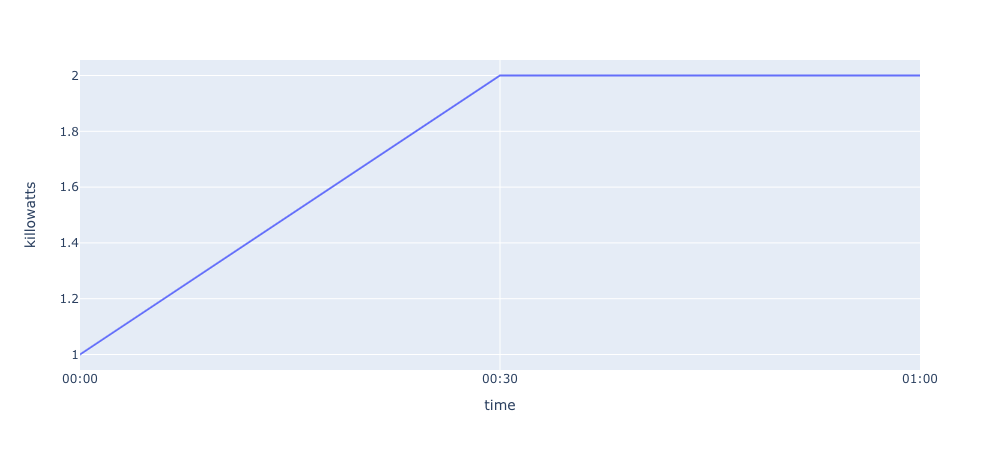

In [9]:
import plotly.express as px

fig = px.line(y=[1, 2, 2], x=["00:00", "00:30", "01:00"], labels={'x':'time', 'y':'killowatts'})
fig.show(renderer="png", width=1000)

This shows power sampled across 1 hour - if we took the `mean(1, 2, 2)` we would have 1.667kWh

If we calculate the area under the chart, treating each pair, we would have 30min at 1.5kW and 30min at 2kW - giving us:

```
mean(1, 2) * (30 / 60) + mean(2, 2) * (30 / 60)

```
Which is 1.75 kWh - quite different from the 1.667 calculated with the more simple method

## Extrapolation of energy consumption within a Settlement Period

When working with energy across an arbitrary time period, there is no extrapolation.

However, when we ask for the energy consumed in a fixed settlement period, we extrapolate power samples to the boundary of the settlement period.

Below, we chart the actual power samples taken within the first hour of data collection:

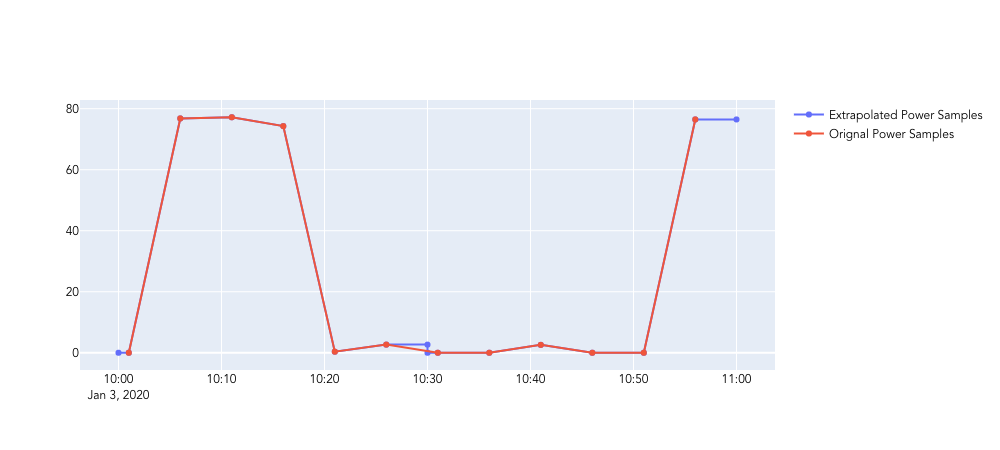

In [10]:
extrapolated_samples = periodical_energies[0].samples + periodical_energies[1].samples
extrapolated_power = pd.DataFrame.from_records([sample.__dict__ for sample in extrapolated_samples])
extrapolated_power

subset = power_sample_data.head(12).copy()
subset['Timestamp in AEST'] = subset.apply(lambda x: NemSettlementPeriod.localize(x['Timestamp']), axis=1)

import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = go.Figure() # make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=extrapolated_power['moment'], y=extrapolated_power['watts'], name="Extrapolated Power Samples")
)

fig.add_trace(
    go.Scatter(x=subset['Timestamp in AEST'], y=subset['Demand (W)'], name="Orignal Power Samples")
)

fig.update_layout(
    font=dict(
        family="Avenir",
        size=12,
        color="#000000"
    )
)

fig.show(renderer="png", width=1000)

You can see that we're extrapolating extra power samples at the period boundaries - 10:00, 10:30 and 11:00.

This results, again, in a different energy calculation; favoring a high level of sample rate.

## Timezone transformations

When dealing in energy, and using a timezone aware settlement period class, the timezone conversion is handled for us.

But the settlement period also has a standalone method to quickly transform a string or datetime into a localized datetime.

We can pass `"2019-01-01 12:00:00+00:00"` into the `NemSettlementPeriod.localize` method to get the datetime in AEST:

In [11]:
NemSettlementPeriod.localize("2019-01-01 12:00:00+00:00")

datetime.datetime(2019, 1, 1, 22, 0, tzinfo=<StaticTzInfo 'Etc/GMT-10'>)

We can apply that to the whole series to quickly transform the Timestamp series of UTC times in our original data.

```
power_sample_data.apply(lambda x: NemSettlementPeriod.localize(x['Timestamp']), axis=1)
```


In [12]:
power_sample_data['Timestamp in AEST'] = power_sample_data.apply(lambda x: NemSettlementPeriod.localize(x['Timestamp']), axis=1)
power_sample_data.head(8)

,Timestamp,Demand (W),power_samples,Timestamp in AEST
0,2020-01-03 00:01:00+00:00,0.00,"WattSample(watts=0.0, moment=Timestamp('2020-0...",2020-01-03 10:01:00+10:00
1,2020-01-03 00:06:00+00:00,76.81,"WattSample(watts=76.81, moment=Timestamp('2020...",2020-01-03 10:06:00+10:00
2,2020-01-03 00:11:00+00:00,77.20,"WattSample(watts=77.2, moment=Timestamp('2020-...",2020-01-03 10:11:00+10:00
3,2020-01-03 00:16:00+00:00,74.29,"WattSample(watts=74.29, moment=Timestamp('2020...",2020-01-03 10:16:00+10:00
4,2020-01-03 00:21:00+00:00,0.35,"WattSample(watts=0.35, moment=Timestamp('2020-...",2020-01-03 10:21:00+10:00
5,2020-01-03 00:26:00+00:00,2.67,"WattSample(watts=2.67, moment=Timestamp('2020-...",2020-01-03 10:26:00+10:00
6,2020-01-03 00:31:00+00:00,0.00,"WattSample(watts=0.0, moment=Timestamp('2020-0...",2020-01-03 10:31:00+10:00
7,2020-01-03 00:36:00+00:00,0.00,"WattSample(watts=0.0, moment=Timestamp('2020-0...",2020-01-03 10:36:00+10:00


## Conclusion

The electric-units package provides some tooling to more explicitly express the power, energy and time values most often encountered in our work.

These objects have conenience methods for data conversion, and take an opinionated approach to calculating energy across time and summariesed within settlement periods.
